# Old Modern portfolio theory

## Efficient frontier, VaR, Expected Shortfall, Bootstrap, Monte-Carlo

In this tutorial, we're going to calculate the efficient frontier based on historical and forecasted data, and then generate some forward-looking returns.

As a starting point we'll use returns of 12 asset classes, namely developed markets bonds(FI.DEV), developed markets equities(EQ.DEV), emerging market bonds (FI.EM), corporate bonds(FI.CORP), emerging market equities(EQ.EM), high yield bonds(FI.HY), inflation-linked bonds(FI.IL), hedge funds(HF), real estate securities(RE.SEC), commodities(COMMOD), private equity(PRIV.EQ), bills(CASH).

In [1]:
#loadind required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import cvxopt as opt
from cvxopt import blas, solvers

In [2]:
#some formatting
pd.options.display.float_format = '{:.02%}'.format #this is to format pandas dataframes nicely
#pd.options.display.float_format = '{:.4f}'.format #this is to format pandas dataframes nicely
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #this is just to show all output for any cell, not the last operator output
solvers.options['show_progress'] = False # Turn off progress printing

In [3]:
myPath = r'...your path...\Data_Source.xlsx'

In [4]:
returns = pd.read_excel(myPath, index_col=0)

In [5]:
returns.head(2)
print('...')
returns.tail(2)

,FI.DEV,EQ.DEV,FI.EM,FI.CORP,EQ.EM,FI.HY,FI.IL,HF,RE.SEC,COMMOD,Private EQ,CASH
1998-02-28,0.66%,6.77%,-0.14%,0.37%,10.44%,0.45%,1.26%,-3.17%,-5.49%,-5.26%,8.02%,0.37%
1998-03-31,-0.88%,4.33%,0.90%,-0.50%,4.23%,0.96%,2.31%,-2.91%,-0.75%,0.98%,2.80%,0.49%


...


,FI.DEV,EQ.DEV,FI.EM,FI.CORP,EQ.EM,FI.HY,FI.IL,HF,RE.SEC,COMMOD,Private EQ,CASH
2015-10-31,-0.16%,7.96%,2.69%,0.61%,7.14%,2.99%,0.69%,-1.68%,-6.25%,1.14%,7.08%,-0.03%
2015-11-30,-1.72%,-0.44%,-0.82%,-1.10%,-3.90%,-2.04%,-1.24%,-0.44%,-2.00%,-7.51%,4.82%,-0.01%


As per the output above, in the input file we have monthly returns for a number of assets from February 1998 to November 2015. It is a good data range because it includes the dotcom crysis, the mortgage buble and consequent recoveries. You can choose your own time horizon. 
If you want do download other data from the internet there is a number of packages to do that. Just don't forget to convert price data to returns.
Let's plot this returns to see relative performance of assets. 

In [6]:
cumulative_returns = returns + 1
for i in range(1,returns.shape[0]):
    cumulative_returns.iloc[i,:] = cumulative_returns.iloc[i,:]*cumulative_returns.iloc[i-1,:]
cumulative_returns -= 1

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'Cumulative return of assets')

Text(0.5,0,'Time')

Text(0,0.5,'Cumilative return, %')

[Text(0,0,'-100%'),
 Text(0,0,'0%'),
 Text(0,0,'100%'),
 Text(0,0,'200%'),
 Text(0,0,'300%'),
 Text(0,0,'400%'),
 Text(0,0,'500%')]

<Figure size 432x288 with 0 Axes>

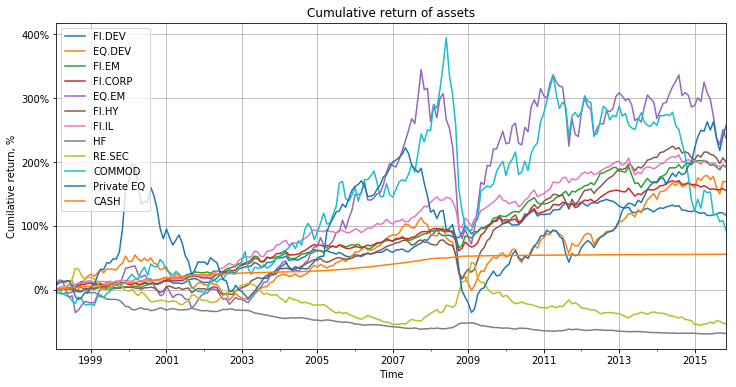

In [7]:
InteractiveShell.ast_node_interactivity = "last"
plt.figure()
cumulative_returns.plot(figsize=(12, 6)) 
plt.title('Cumulative return of assets')
plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Cumilative return, %')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid(True)

The worst performing classes are hedge funds and real estate securities. Maybe the indices chosen are not representative. However, since it is only an exercise, we'll leave averything as it is.
Let's calculate parameters of these returns.

In [8]:
#function for historical VaR and CVaR calculation
def __return_sorted_columns(df):
    sorted_df = pd.DataFrame(columns=df.columns)
    for col in df:
        sorted_df[col] = sorted(df[col])
    return sorted_df

def var_historical(rtns, confidence=.95):
    sorted_rtns = __return_sorted_columns(rtns)
    ind = int(np.floor(len(rtns)*(1-confidence))) #better to take lower value to overestimate the risk than to underestimate it
    return sorted_rtns.iloc[ind-1]

def cvar_historical(rtns, confidence=.95):
    sorted_rtns = __return_sorted_columns(rtns)
    ind = int(np.floor(len(rtns)*(1-confidence))) #better to take lower value to overestimate the risk than to underestimate it
    return np.mean(sorted_rtns[0:ind])

def var_analytical(rtns, confidence=.95):
    mu = rtns.mean() # in some cases mean return may assumed to be zero
    std = rtns.std()
    return mu - std*norm.ppf(confidence)

def cvar_analytical(rtns, confidence=.95):
    mu = rtns.mean() # in some cases mean return may assumed to be zero
    std = rtns.std()
    return mu - std*norm.pdf(norm.ppf(confidence))/(1-confidence)


def calculateparameters(rtns, confidence=.95):
    """This function returns Mean return, Standard deviation, Historical VaR, Historical CVaR, Analytical VaR, Analytical CVaR
    Parameters
    ----------
    rtns (pandas dataframe): asset returns
    """
    mean_asset_rtn = rtns.mean()
    std_asset_rtn = rtns.std()
    VaR_hist = var_historical(rtns, confidence)
    CVaR_hist = cvar_historical(rtns, confidence)
    VaR_covar = var_analytical(rtns, confidence)
    CVaR_covar = cvar_analytical(rtns, confidence)
    params = pd.concat([mean_asset_rtn, std_asset_rtn,VaR_hist, CVaR_hist, VaR_covar, CVaR_covar], axis=1)
    params = params.transpose()
    params.index = ['Mean return','Standard deviation', 'Historical VaR', 'Historical CVaR', 
                    'Analytical VaR', 'Analytical CVaR']
    return params

In [9]:
calculateparameters(returns)

,FI.DEV,EQ.DEV,FI.EM,FI.CORP,EQ.EM,FI.HY,FI.IL,HF,RE.SEC,COMMOD,Private EQ,CASH
Mean return,0.38%,0.57%,0.52%,0.46%,0.82%,0.56%,0.52%,-0.52%,-0.23%,0.53%,0.87%,0.21%
Standard deviation,1.82%,4.58%,1.88%,1.82%,6.98%,2.91%,2.16%,2.02%,5.14%,6.70%,7.38%,0.20%
Historical VaR,-2.97%,-8.53%,-2.82%,-2.54%,-10.48%,-3.97%,-3.40%,-3.48%,-6.99%,-11.23%,-11.30%,0.00%
Historical CVaR,-3.59%,-10.94%,-4.65%,-4.04%,-16.28%,-7.21%,-4.95%,-4.47%,-8.96%,-14.55%,-16.85%,-0.01%
Analytical VaR,-2.61%,-6.96%,-2.58%,-2.53%,-10.66%,-4.22%,-3.02%,-3.84%,-8.69%,-10.49%,-11.28%,-0.12%
Analytical CVaR,-3.37%,-8.88%,-3.36%,-3.29%,-13.58%,-5.44%,-3.93%,-4.69%,-10.83%,-13.29%,-14.36%,-0.21%


As we can see, historical VaR slightly overestimates the risk. It happens because we round the index of the historical return correspondent to the chosen confidence level.


We can generate expected returns using bootstrap or covariance based Monte-Carlo.

In [10]:
def montecarlo(rtns, num_simulations = 10000, seed=1):
    '''Covariance based Monte-Carlo, returns are assumed to be normally distributed
    '''
    n_assets = rtns.shape[1]
    mean_asset_rtn = rtns.mean()
    std_asset_rtn = rtns.std()
    cormat = rtns.corr()
    np.random.seed(seed)
    rand_rtns = (np.random.normal(size=num_simulations*n_assets)).reshape(num_simulations,n_assets)
    cholesky_decomposition = (np.linalg.cholesky(cormat)).transpose()
    zscore = np.dot(rand_rtns, cholesky_decomposition)
    
    rtns_simulations = pd.DataFrame(columns=rtns.columns)
    #haven't found an elegant way to do this. Ended up with a loop. There should be some convenient function in numpy or pandas...
    for i in range(zscore.shape[0]):
        rtns_simulations.loc[i] = mean_asset_rtn + np.multiply(zscore[i,:],std_asset_rtn)
    return rtns_simulations

def bootstrap(rtns, num_simulations = 10000, chunksize = 3, seed=1):
    '''Takes historical data to generate returns
    '''
    n_returns = rtns.shape[0]
    if (chunksize<1):
        chunksize = 1
        print('Chunksize cannot be negative. chunksize is assumed to be 1')
        
    returns_local = rtns.append(rtns.iloc[0:(chunksize-1),:]) #this is to be able to take pieces from the end of the series
    chunks = num_simulations//chunksize
    rtns_simulations = pd.DataFrame(columns=rtns.columns)
    np.random.seed(seed)
    for idx in np.random.choice(n_returns, size=chunks, replace=True):
        rtns_simulations = rtns_simulations.append(returns_local.iloc[idx:(idx+chunksize),:])
    
    #adding variables which are lower than 
    fraction_period = num_simulations%chunksize
    if fraction_period:
        idx = np.random.randint(n_returns)
        rtns_simulations = rtns_simulations.append(returns_local.iloc[idx:(idx+fraction_period),:])
    
    rtns_simulations.index = range(num_simulations)
    
    return rtns_simulations

In [11]:
bootstrap_returns = bootstrap(returns)
montecarlo_returns = montecarlo(returns)

Parameters of returns generated with bootstrap:

In [12]:
calculateparameters(bootstrap_returns)

,FI.DEV,EQ.DEV,FI.EM,FI.CORP,EQ.EM,FI.HY,FI.IL,HF,RE.SEC,COMMOD,Private EQ,CASH
Mean return,0.38%,0.61%,0.51%,0.45%,0.82%,0.53%,0.52%,-0.53%,-0.27%,0.51%,0.78%,0.20%
Standard deviation,1.82%,4.55%,1.89%,1.81%,6.88%,2.91%,2.16%,2.01%,5.09%,6.69%,7.36%,0.20%
Historical VaR,-2.83%,-8.42%,-2.75%,-2.52%,-9.99%,-3.94%,-3.03%,-3.45%,-6.84%,-10.65%,-11.07%,0.00%
Historical CVaR,-3.53%,-10.67%,-4.52%,-3.92%,-15.51%,-7.13%,-4.86%,-4.48%,-8.56%,-14.45%,-16.81%,-0.01%
Analytical VaR,-2.61%,-6.88%,-2.60%,-2.53%,-10.49%,-4.26%,-3.03%,-3.84%,-8.65%,-10.50%,-11.33%,-0.12%
Analytical CVaR,-3.37%,-8.79%,-3.39%,-3.28%,-13.36%,-5.47%,-3.94%,-4.68%,-10.78%,-13.30%,-14.40%,-0.21%


Parameters of returns generated with Monte-Carlo:

In [13]:
calculateparameters(montecarlo_returns)

,FI.DEV,EQ.DEV,FI.EM,FI.CORP,EQ.EM,FI.HY,FI.IL,HF,RE.SEC,COMMOD,Private EQ,CASH
Mean return,0.37%,0.49%,0.52%,0.46%,0.80%,0.56%,0.52%,-0.51%,-0.16%,0.57%,0.78%,0.21%
Standard deviation,1.83%,4.56%,1.89%,1.82%,6.93%,2.91%,2.16%,2.01%,5.15%,6.69%,7.43%,0.20%
Historical VaR,-2.63%,-6.85%,-2.59%,-2.54%,-10.73%,-4.20%,-3.02%,-3.79%,-8.62%,-10.54%,-11.32%,-0.12%
Historical CVaR,-3.44%,-8.76%,-3.41%,-3.24%,-13.56%,-5.42%,-3.90%,-4.64%,-10.74%,-13.15%,-14.39%,-0.20%
Analytical VaR,-2.63%,-7.00%,-2.59%,-2.52%,-10.59%,-4.23%,-3.03%,-3.81%,-8.62%,-10.44%,-11.43%,-0.12%
Analytical CVaR,-3.39%,-8.91%,-3.38%,-3.28%,-13.49%,-5.44%,-3.93%,-4.65%,-10.77%,-13.24%,-14.53%,-0.20%


As we can see, generated returns have almost the same parameters as our initial sample, which confirms that the generation functions work correctly.

Let's visualize the result, people love it. We can make a density plot for returns of equities.

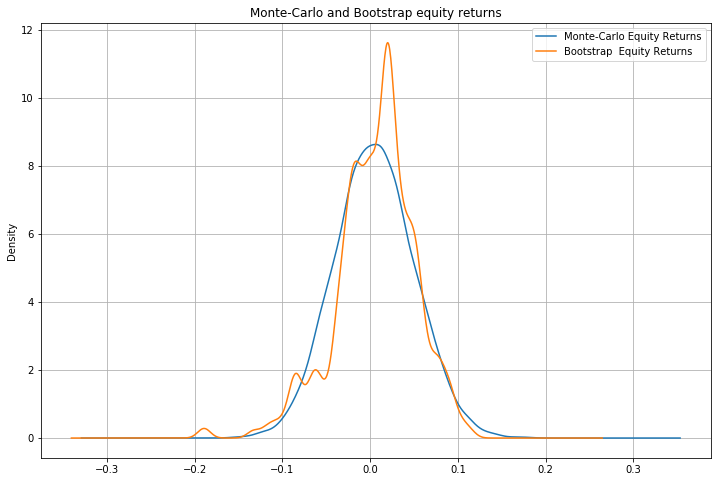

In [14]:
equity_returns_for_plotting = pd.concat([montecarlo_returns['EQ.DEV'], bootstrap_returns['EQ.DEV']],axis=1)
equity_returns_for_plotting.columns=['Monte-Carlo Equity Returns','Bootstrap  Equity Returns']
fig, ax = plt.subplots(figsize=(12, 8))
equity_returns_for_plotting.plot.kde(ax=ax, legend=True, title='Monte-Carlo and Bootstrap equity returns')
#equity_returns_for_plotting.plot.hist(density=True, ax=ax)
ax.grid(axis='x')
ax.grid(axis='y')
#ax.set_facecolor('#d8dcd6')

The return generated by Monte-Carlo is more smooth. Seems like bootstrap returns have fatter tails.

Let's annualize our monthly returns. We'll proceed with bootstrap returns.

In [15]:
def returns_period_upscale(rtns, periodicity = 12, annualize_last = True):
    new_returns = pd.DataFrame(columns = rtns.columns)
    rtns += 1
    n_steps = rtns.shape[0]//periodicity
    
    for i in range(n_steps):
        new_returns.loc[i] = np.prod(rtns.iloc[(i*periodicity):((i+1)*periodicity)],axis=0)
    
    fraction_period = rtns.shape[0]%periodicity
    if fraction_period:
        new_returns.loc[n_steps] = np.prod(rtns.iloc[(n_steps*periodicity):],axis=0)
        if annualize_last: new_returns.loc[n_steps] = np.power(new_returns.loc[n_steps],periodicity/fraction_period)
    
    rtns -= 1 #python passes this dataframe by reference, and we don't want the internal function to make changes. I should've copied this Dataframe at the beginning of the function, and work with the copy. But I don't want to)
    
    return new_returns-1

In [16]:
annual_returns = returns_period_upscale(bootstrap_returns)

In [17]:
covmat, corrmat = [returns.cov(), returns.corr()]
corrmat.style.background_gradient(cmap='coolwarm').set_precision(2)

,FI.DEV,EQ.DEV,FI.EM,FI.CORP,EQ.EM,FI.HY,FI.IL,HF,RE.SEC,COMMOD,Private EQ,CASH
FI.DEV,1,0.053,0.47,0.76,0.053,0.1,0.73,0.03,0.12,0.11,-0.19,0.16
EQ.DEV,0.053,1,0.39,0.45,0.84,0.71,0.37,-0.83,-0.63,0.35,0.72,-0.15
FI.EM,0.47,0.39,1,0.72,0.43,0.58,0.68,-0.37,-0.41,0.14,0.26,0.0016
FI.CORP,0.76,0.45,0.72,1,0.42,0.59,0.88,-0.38,-0.22,0.35,0.16,0.0062
EQ.EM,0.053,0.84,0.43,0.42,1,0.7,0.36,-0.86,-0.61,0.43,0.67,-0.12
FI.HY,0.1,0.71,0.58,0.59,0.7,1,0.5,-0.68,-0.57,0.36,0.58,-0.2
FI.IL,0.73,0.37,0.68,0.88,0.36,0.5,1,-0.32,-0.17,0.37,0.11,0.027
HF,0.03,-0.83,-0.37,-0.38,-0.86,-0.68,-0.32,1,0.57,-0.44,-0.74,0.071
RE.SEC,0.12,-0.63,-0.41,-0.22,-0.61,-0.57,-0.17,0.57,1,-0.12,-0.74,0.15
COMMOD,0.11,0.35,0.14,0.35,0.43,0.36,0.37,-0.44,-0.12,1,0.22,-0.045


Below you can see an average return(arithmetic), standard deviation by asset class and correlation and covariation matrix. Geometric returns can be used instead, but the difference is small anyway.

In [18]:
mean_asset_rtn, std_asset_rtn = [annual_returns.mean(), annual_returns.std()]
#printing parameters
params = pd.DataFrame(columns=mean_asset_rtn.index, index = ['Mean_return','Standard_deviation'])
for key, rtn, stdev in zip(mean_asset_rtn.index, mean_asset_rtn, std_asset_rtn):
    params[key] = [f'{rtn*100:.02f}%', f'{stdev*100:.02f}%']
params

,FI.DEV,EQ.DEV,FI.EM,FI.CORP,EQ.EM,FI.HY,FI.IL,HF,RE.SEC,COMMOD,Private EQ,CASH
Mean_return,4.68%,7.78%,6.21%,5.60%,11.16%,6.72%,6.34%,-6.01%,-2.46%,6.55%,12.08%,2.46%
Standard_deviation,6.77%,18.10%,6.44%,6.87%,29.77%,12.66%,7.35%,8.18%,22.53%,25.08%,35.56%,1.20%


It seems like equities are doing better than bonds, however equities are more volitile. Makes sense.
Let's take a look at correlation matrix

In [19]:
covmat, corrmat = [annual_returns.cov(), annual_returns.corr()]
corrmat.style.background_gradient(cmap='coolwarm').set_precision(2)

,FI.DEV,EQ.DEV,FI.EM,FI.CORP,EQ.EM,FI.HY,FI.IL,HF,RE.SEC,COMMOD,Private EQ,CASH
FI.DEV,1,-0.15,0.35,0.65,-0.071,-0.0069,0.58,0.23,0.37,-0.041,-0.37,0.11
EQ.DEV,-0.15,1,0.29,0.44,0.83,0.76,0.39,-0.84,-0.7,0.44,0.78,-0.21
FI.EM,0.35,0.29,1,0.69,0.37,0.58,0.64,-0.34,-0.32,0.1,0.17,-0.11
FI.CORP,0.65,0.44,0.69,1,0.42,0.66,0.87,-0.35,-0.21,0.34,0.14,-0.099
EQ.EM,-0.071,0.83,0.37,0.42,1,0.72,0.41,-0.84,-0.62,0.48,0.71,-0.15
FI.HY,-0.0069,0.76,0.58,0.66,0.72,1,0.57,-0.71,-0.58,0.49,0.56,-0.3
FI.IL,0.58,0.39,0.64,0.87,0.41,0.57,1,-0.36,-0.21,0.42,0.12,-0.086
HF,0.23,-0.84,-0.34,-0.35,-0.84,-0.71,-0.36,1,0.68,-0.48,-0.79,0.034
RE.SEC,0.37,-0.7,-0.32,-0.21,-0.62,-0.58,-0.21,0.68,1,-0.34,-0.71,0.19
COMMOD,-0.041,0.44,0.1,0.34,0.48,0.49,0.42,-0.48,-0.34,1,0.35,-0.091


Intuitively, high correlation between assets - a bad thing, low correlation - a good thing. 

In [20]:
def __solve_portfolio(S, pbar, G, h, A, b, pmultiplier):
    '''Solves quadratic problem and returns weights and correcpondong return and risk
    '''
    x = solvers.qp(S, -pmultiplier*pbar, G, h, A=A, b=b)['x']
    return np.array(x), blas.dot(pbar, x), np.sqrt(blas.dot(x, S*x))

def efficient_frontier(rtns, num_eff_ports = 15, min_weights_vect=None, max_weights_vect=None):
    '''Returns [array of weights, return, volatility]
    you can specify min. and max weights for simulation, like min_weights_vect = [0, .10, ..., -.20] 
    '''
    n = rtns.shape[1]
    #calculate returns and covariance
    S = opt.matrix(np.matrix(rtns.cov()))
    pbar = opt.matrix(np.mean(rtns))
    
    #by default an asset weight is from 0 to 100% (no leverage, no borrowing)
    if min_weights_vect is None: min_weights_vect=[0]*n 
    if max_weights_vect is None: max_weights_vect=[1]*n 
        
    
    # Create constraint matrices
    G = None
    h = None
    if not min_weights_vect is None:
        G = -np.eye(n)
        h = np.matrix(min_weights_vect)
    if not max_weights_vect is None:
        G = np.concatenate((G,np.eye(n)))
        h = np.concatenate((h, np.matrix(max_weights_vect)), axis=1)#recheck that weights are set up correctly
    if (not min_weights_vect is None) or (not max_weights_vect is None):
        G = opt.matrix(G)   # negative n x n identity matrix
        h = opt.matrix(h, (h.shape[1],1), 'd')
    #we can add group counstraints later if required
    
    A = opt.matrix(1.0, (1, n)) #sum of weights should be equal to 1
    b = opt.matrix(1.0)
    
    minVarPort = __solve_portfolio(S, pbar, G, h, A, b, 0)
    maxRtnPort = __solve_portfolio(S, pbar, G, h, A, b, 10E5)
    
    target_returns = np.linspace(minVarPort[1], maxRtnPort[1], num_eff_ports-1, endpoint=False)
    
    frontier = list()
    frontier.append(minVarPort)
    for target_rtn in target_returns[1:]:
        port = __solve_portfolio(S, 
                                 pbar, 
                                 G, 
                                 h, 
                                 opt.matrix(np.concatenate((np.matrix([1]*n),np.transpose(pbar)))), #adjust Amat to add return target
                                 opt.matrix([1.0, target_rtn], (2,1)), #adjust bvac to add return target
                                 0
                                )
        frontier.append(port)
    frontier.append(maxRtnPort)

    return frontier

Wow, all is set up to find our efficient frontier and earn billions of dollars. 
We'll use annualised returns, because compuunding effect is taken into account.

In [21]:
front = efficient_frontier(annual_returns)

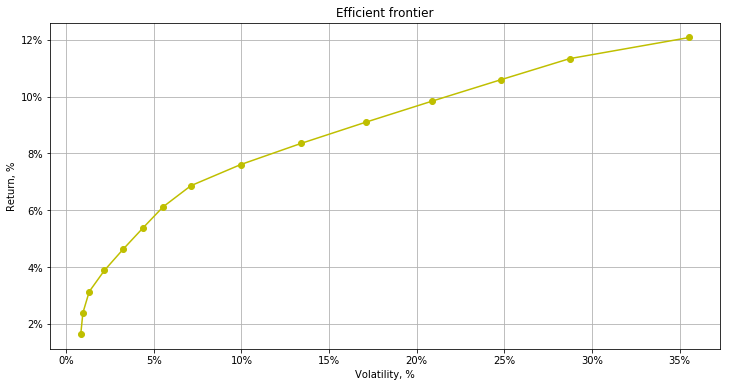

In [22]:
plt.figure(figsize=(12, 6))
plt.plot([std for _,_,std in front], [rtn for _, rtn, _ in front],'y-o')
plt.title('Efficient frontier')
plt.xlabel('Volatility, %')
plt.ylabel('Return, %')
plt.gca().set_yticklabels(['{:.00f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.gca().set_xticklabels(['{:.00f}%'.format(x*100) for x in plt.gca().get_xticks()])
plt.grid(True)

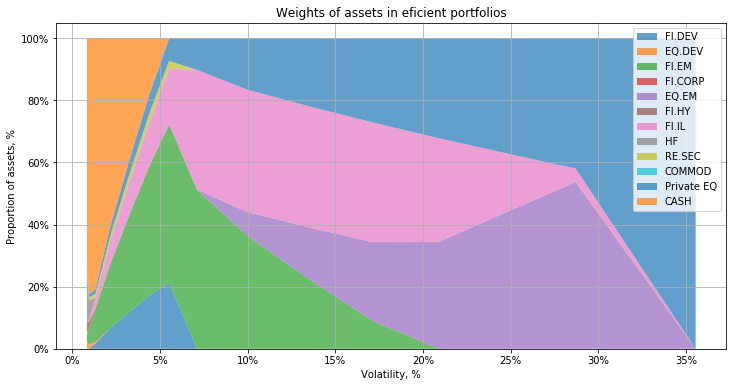

In [25]:
wt = np.concatenate([w for w, _, _ in front], axis=1)
plt.figure(figsize=(12, 6))
plt.title('Weights of assets in eficient portfolios')
plt.stackplot([std for _ , _,std in front], wt, labels = annual_returns.columns, alpha=.7)
plt.gca().set_yticklabels(['{:.00f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.gca().set_xticklabels(['{:.00f}%'.format(x*100) for x in plt.gca().get_xticks()])
plt.legend(loc='upper right')
plt.ylabel('Proportion of assets, %')
plt.xlabel('Volatility, %')
plt.grid(True)

In [24]:
pd.DataFrame(np.transpose(np.concatenate([w for w, _, _ in front], axis=1)), 
            [std for _ , _,std in front], 
            columns=annual_returns.columns)

,FI.DEV,EQ.DEV,FI.EM,FI.CORP,EQ.EM,FI.HY,FI.IL,HF,RE.SEC,COMMOD,Private EQ,CASH
0.84%,0.00%,2.31%,2.16%,0.00%,0.64%,3.35%,0.02%,15.93%,0.21%,0.37%,1.34%,73.67%
0.96%,0.07%,1.34%,4.77%,0.02%,0.00%,2.55%,0.71%,6.14%,0.80%,0.16%,1.01%,82.42%
1.32%,1.69%,0.48%,10.56%,0.00%,0.00%,0.18%,3.47%,0.00%,1.27%,0.06%,1.43%,80.87%
2.19%,6.68%,0.00%,20.77%,0.00%,0.00%,0.00%,7.36%,0.00%,1.78%,0.01%,3.09%,60.31%
3.26%,11.82%,0.00%,31.14%,0.00%,0.00%,0.00%,10.63%,0.00%,2.41%,0.00%,4.60%,39.40%
4.38%,17.00%,0.00%,41.54%,0.00%,0.00%,0.00%,13.83%,0.00%,3.03%,0.02%,6.10%,18.47%
5.53%,21.26%,0.00%,50.99%,0.00%,0.00%,0.00%,17.88%,0.00%,2.55%,0.01%,7.30%,0.01%
7.12%,0.00%,0.00%,51.21%,0.00%,0.00%,0.00%,38.58%,0.00%,0.00%,0.00%,10.21%,0.00%
9.96%,0.00%,0.00%,36.51%,0.00%,7.56%,0.00%,39.40%,0.00%,0.00%,0.00%,16.53%,0.00%
13.41%,0.00%,0.00%,22.80%,0.00%,16.41%,0.00%,38.99%,0.00%,0.00%,0.00%,21.79%,0.00%


So, if you don't like risk - CASH is your choise. If you're ready to take risks to achieve high return - invest in private equities. In-between - diversify your portfolio.